# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [2]:
from collections import namedtuple

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

HWC = namedtuple("HWC", ["h", "w", "c"])
HWC.__new__.__defaults__ = (0, 0, 0)
HWC.__str__ = lambda d: f"HWC({d.h},{d.w},{d.c})"

In [3]:
from utils import get_dataset


In [4]:
%matplotlib inline
COLORMAP = {1: "red", 2: "blue", 4: "green"}
MAPPING_CLASS = {1: "vehicles", 2: "pedestrian", 4: "cyclist"}

In [5]:
dataset = get_dataset("data/waymo/training_and_validation/*.tfrecord")
#dataset = get_dataset("data/waymo/train/*.tfrecord")
#dataset = get_dataset("data/waymo/validation/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['data/waymo/training_and_validation/*.tfrecord']


2022-04-22 19:01:01.521365: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (34)


INFO:tensorflow:Reading record datasets for input file: ['data/waymo/training_and_validation/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 97
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [6]:
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    image = batch["image"].numpy()
    image_size = HWC(*image.shape)

    f, ax = plt.subplots()
    ax.imshow(image)
    bboxes = batch["groundtruth_boxes"].numpy()
    classes = batch["groundtruth_classes"].numpy()
    for cl, bb in zip(classes, bboxes):
        y1, x1, y2, x2 = bb
        y1, y2 = int(y1*image_size.h), int(y2*image_size.h)
        x1, x2 = int(x1*image_size.w), int(x2*image_size.w)
        rec = Rectangle((x1, y1), x2- x1, y2-y1, facecolor='none', edgecolor=COLORMAP[cl])
        ax.add_patch(rec)
    ax.axis('off')
    ax.set_title(batch["filename"].numpy().decode(), color = "gray")
    #f.savefig(batch["filename"].numpy().decode()+".png")


## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

<Figure size 432x288 with 0 Axes>

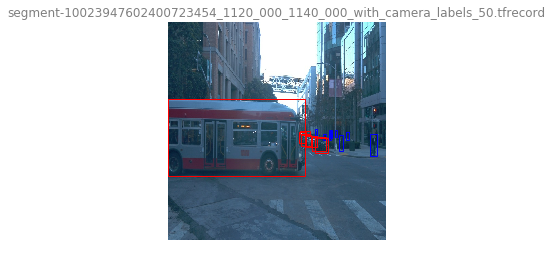

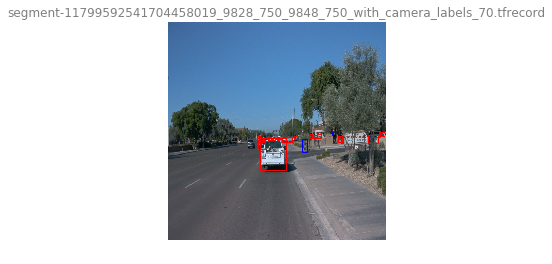

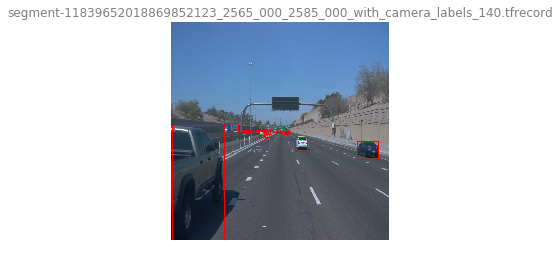

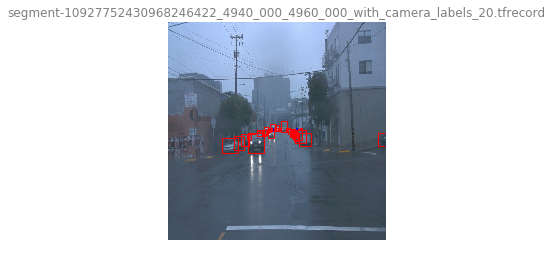

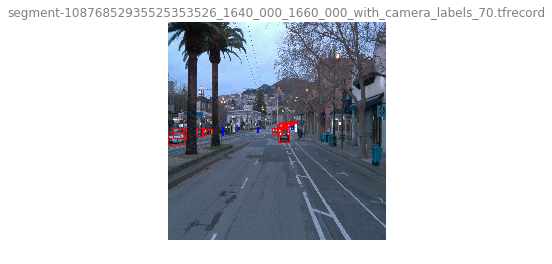

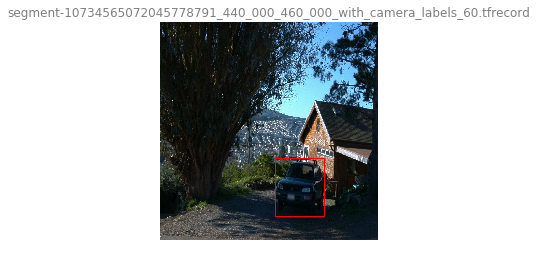

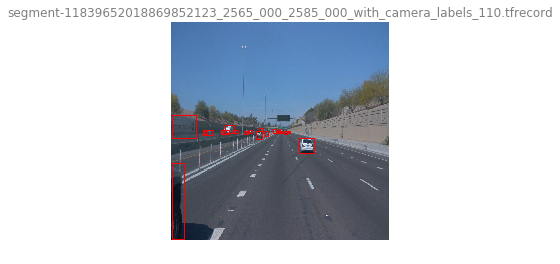

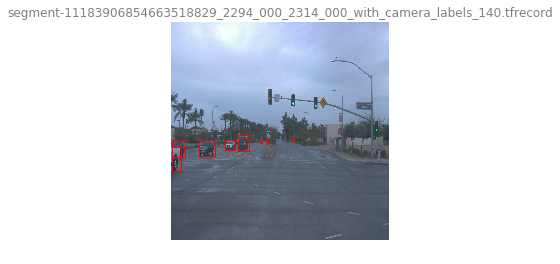

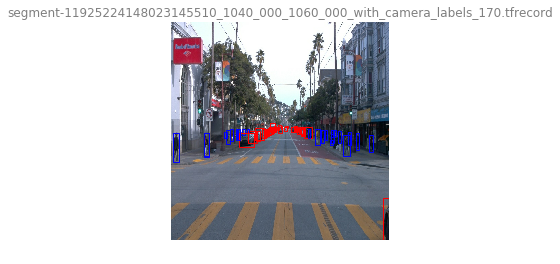

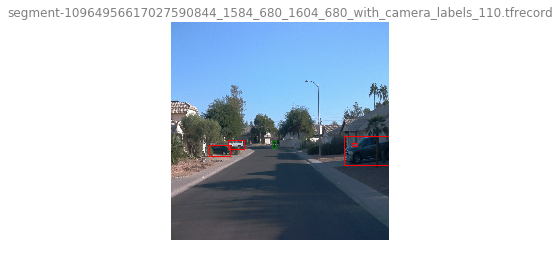

In [30]:
plt.close("all")
BATCH_SIZE_DISPLAY = 10
batch = dataset.shuffle(BATCH_SIZE_DISPLAY, reshuffle_each_iteration=True)
plt.figure()
for idx in np.arange(BATCH_SIZE_DISPLAY):
    for t in batch.take(1):
        display_instances(t)
plt.show()



## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

Due to the size of the dataset, we will focus an a restricted batch of images(defined by the user) to perform data analysys such as:

>- Class Distribution: used to identify if a class is more represented in the dataset. If yes, may or may not require a class compensation through Data Augmentation or Data Acquisition, depending of the use case.
>- Number of instances/object per image: Allow to know if the dataset is based on scenes with high density objects and further to have better train/validation split, data augmentation, etc.
>- Number of each class per image: can be usefull for data augmentation
>- Image Brightness: can be usefull for data augmentation, weather robustness, etc

In [7]:
BATCH_SIZE_ANALYSIS = 50000

distri = {1: [], 2: [], 4: []}
nb_obj_per_img = {"max" : 0, "mean" : 0, "min": 0}
brightness = {"max" : [], "mean" : [], "min": []}
from PIL import Image
id = 0
for idx,batch in enumerate(dataset.take(BATCH_SIZE_ANALYSIS)):
    img = batch["image"].numpy()
    PIL_image = np.asarray(Image.fromarray(np.uint8(img)).convert('L'))
    brightness["max"].append(np.max(PIL_image))
    brightness["min"].append(np.min(PIL_image))
    brightness["mean"].append(np.mean(PIL_image))

    classes = batch["groundtruth_classes"].numpy().tolist()

    for idx_distri in distri.keys():
        distri[idx_distri].append(classes.count(idx_distri))

    nb_obj_per_img["max"] = max(nb_obj_per_img["max"], len(classes))
    nb_obj_per_img["min"] = min(nb_obj_per_img["min"], len(classes))
    nb_obj_per_img["mean"] = (((nb_obj_per_img["mean"] + len(classes)) / 2) if idx!=0 else len(classes))
    id += 1

print("How many objects/instances per Image:")
print(f"         Maximum Nb of Instances: {nb_obj_per_img['max']}")
print(f"         Average Nb of Instances: {nb_obj_per_img['mean']}")
print(f"         Minimum Nb of Instances: {nb_obj_per_img['min']}")

How many objects/instances per Image:
         Maximum Nb of Instances: 76
         Average Nb of Instances: 25.30649395375648
         Minimum Nb of Instances: 0


### Brightness Analysis

Mean Brightness : 97.65648748510745


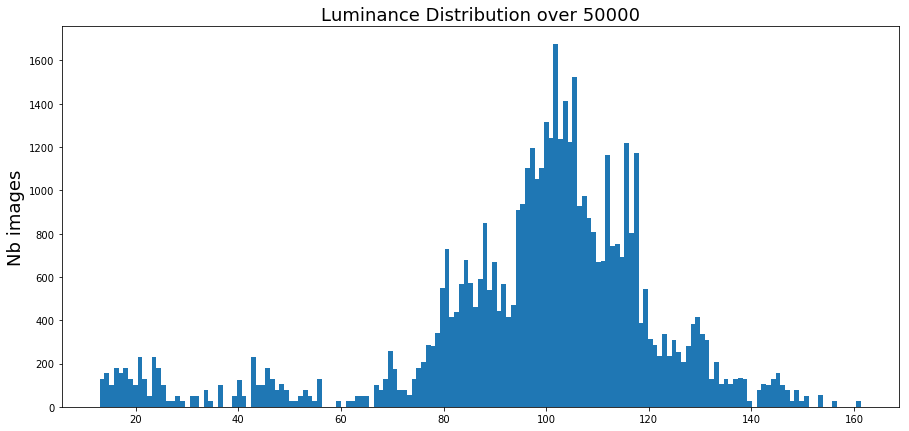

In [8]:
fig = plt.figure(figsize=(15,7))
print(f"Mean Brightness : {np.mean(brightness['mean'])}")
fig.patch.set_facecolor('white')
x = np.arange(len(brightness["mean"]))
plt.hist(brightness["mean"],max(brightness["mean"]).astype(np.int32))

plt.ylabel('Nb images', fontsize=18)
plt.title(f'Luminance Distribution over {BATCH_SIZE_ANALYSIS}', fontsize=18)
plt.show()
#fig.savefig("hist_luminance.png")

### Classes Distribution

CYCLIST represents 899590/1175498 = 76.53%
CYCLIST represents 268897/1175498 = 22.88%
CYCLIST represents 7011/1175498 = 0.6%


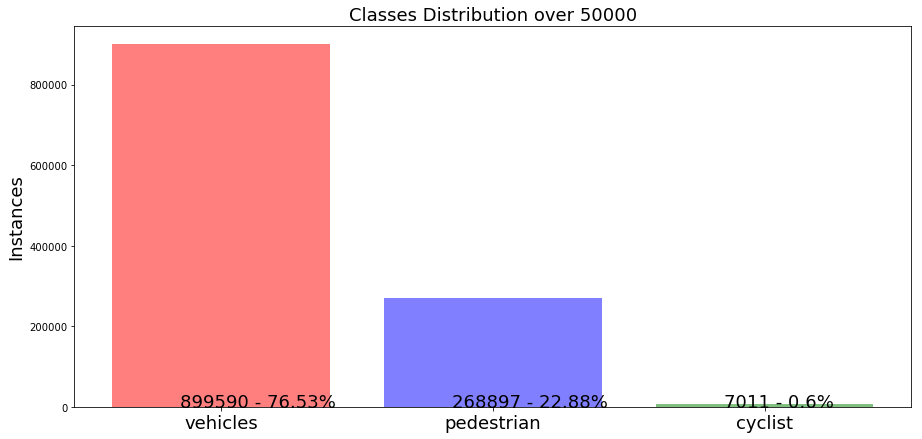

In [9]:
fig = plt.figure(figsize=(15,7))
fig.patch.set_facecolor('white')
total = 0
for idx, name in MAPPING_CLASS.items():
    total+=sum(distri[idx])
    plt.bar(name, sum(distri[idx]), align='center', alpha=0.5, color=COLORMAP[idx])
    

plt.xticks(np.arange(len(MAPPING_CLASS.values())), MAPPING_CLASS.values(), fontsize=18)
plt.ylabel('Instances', fontsize=18)
plt.title(f'Classes Distribution over {BATCH_SIZE_ANALYSIS}', fontsize=18)
tmp=[sum(distri[idx]) for idx in MAPPING_CLASS.keys()]
for i, v in enumerate(tmp):
    plt.text(i-.15, v/tmp[i]+100, f"{tmp[i]} - {round(tmp[i]*100/total, 2)}%", fontsize=18, color="black")
    print(f"{name.upper()} represents {tmp[i]}/{total} = {round(tmp[i]*100/total, 2)}%")
plt.show()
#fig.savefig("distri_classes.png")

### Class distribution per image

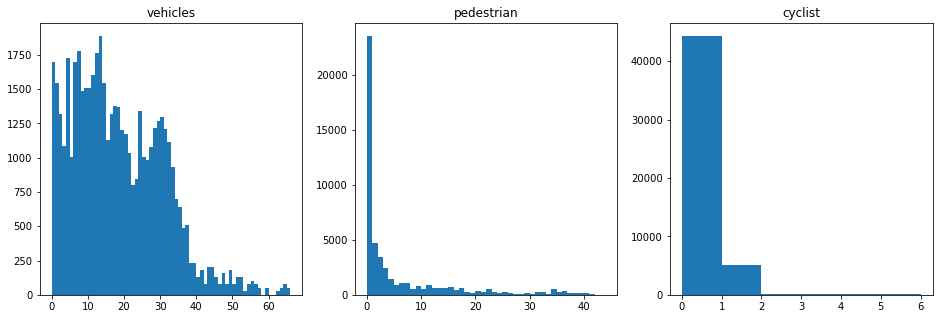

In [10]:
fig, ax = plt.subplots(1,len(distri.keys()), figsize=(16,5))
fig.patch.set_facecolor('white')
for idx in np.arange(len(distri.keys())):
    key = list(distri.keys())[idx]
    ax[idx].hist(distri[key], max(distri[key]))
    ax[idx].set_title(MAPPING_CLASS[key])
plt.show()
#fig.savefig("class_distr_per_img.png")